# Linear Regression in TensorFlow

Although TensorFlow is primarily used to build deep neural networks, 
we can use it as a library to solve mathematical or statistical problems
as well.

We use the example of linear regression to illustrate how TensorFlow
can be used as a "general purpose tool"

In this example we will determine the free parameters $m$ and $b$ of a simple
linear regression line given by $y = m\cdot x + b$.

We will also generate some toy data according to the above model and add some random  Gaussian noise.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6

print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
2.1.0


## Generate example data

We use the same model we will fit to the data to illustrate the main approach and add some random noise.

Instead of using the Normal distribution from numpy or other libraries, we use the one from TensorFlow.


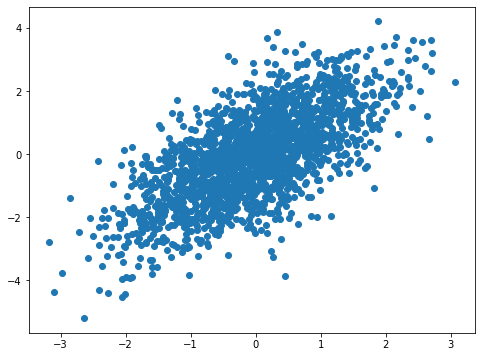

In [2]:
n_samples = 2000
true_slope = 1.0
offset = 0.0

#generate some x_values using a standard Gaussian
x_data = tf.random.normal([n_samples])
noise = tf.random.normal([n_samples])
y_data = true_slope * x_data + offset + noise


#show the generated sample
plt.scatter(x_data,y_data)
plt.show()

## Linear Regression

We now define the model we are going to fit $y = m\cdot x + b$. $x$ is the independent variable, $y$ the dependent.
The model has two free parameteers $m$ and $b4 which we treat as variables.
We initialize each variable with a random number drawn from a standard Normal distribution.

In [3]:
m = tf.Variable(tf.random.normal([1]))
b = tf.Variable(tf.random.normal([1]))

We fit the model using gradient descent which is essentially an optimization problem following the slope
of the gradient of a loss function. We need to define which method we want to use to follow
the gradient. Several choices exist, as a good practice, the Adam Optimizer (See the [paper](https://arxiv.org/abs/1412.6980)
and the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) for more details) is a good starting point

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

We now need to define the optimization procedure.
Essentially, we define a loss function and then compute the gradient and follow the gradient
until we reach a viable minimum.

We use the mean squared error as loss function: $$MSE = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$$
where $y_i$ are the true values and $\hat{y}_i$ are the predictions with the current parameter values.

We can use TensorFlow's ```GradientTape``` method to automatically compute the gradient of the loss
function.
The "Gradient" refers to the functionality of computing the gradient, the "tape" indicates that the operations and results
are recorded so that we can access them later.

The gradient itself is computed via a call to the ```gradient``` method, higher order derivatives can be obtained by subsequent
calls to this method. 
In order to compute the gradient of the loss function, we pass the current value of the loss function
as well as all (trainiable) variables of the model, in our case the slope $m$ and the intercept $b$.

We then need to pass the computed gradient to the optimizer so that the optimizer can change the variable values accordingly.

In [5]:
loss_values = []
steps = []
for i in range(500):
    with tf.GradientTape() as tape:
        y = m*x_data + b
        loss = tf.reduce_mean(tf.square(y - y_data))
        grad = tape.gradient(loss,[m,b])
    optimizer.apply_gradients(zip(grad, [m,b]))
    
    #save the loss values for later visualisation
    loss_values.append(loss)
    steps.append(i)
    if i%50 ==0:
        print("Step {:03d}, loss: {:.3f}".format(i,loss.numpy()))

print("Final loss: {:.3f}".format(loss.numpy()))
print("Final values: m={}, b = {}".format(m.numpy(), b.numpy()))

Step 000, loss: 8.471
Step 050, loss: 5.430
Step 100, loss: 3.497
Step 150, loss: 2.362
Step 200, loss: 1.727
Step 250, loss: 1.384
Step 300, loss: 1.208
Step 350, loss: 1.123
Step 400, loss: 1.085
Step 450, loss: 1.070
Final loss: 1.064
Final values: m=[0.9374815], b = [0.00850761]


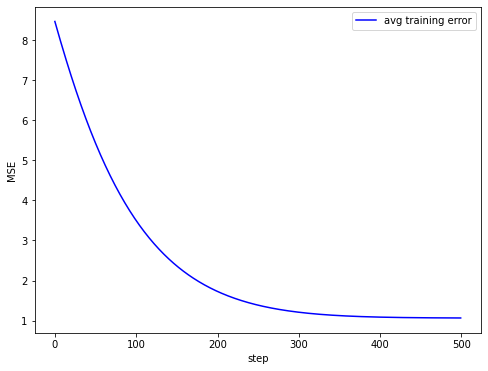

In [6]:
# Visualize the resutls
plt.plot(np.asarray(steps), loss_values, 'b', label="avg training error")
plt.legend(loc="upper right")
#plt.yscale('log')
plt.xlabel('step')
plt.ylabel('MSE')
plt.show()

# Results

We now compare the fitted model with the data and the original function we used to create the dataset with:



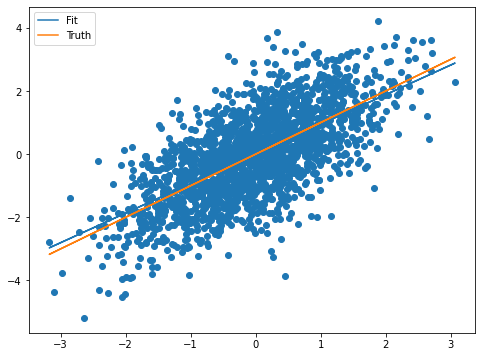

In [7]:
y_true  = true_slope*x_data + offset
y_pred  = m*x_data + b

plt.scatter(x_data,y_data)
plt.plot(x_data, y_pred, label='Fit')
plt.plot(x_data, y_true, label='Truth')
plt.legend()
plt.show()

# Improve the code

The above model was very simple and we could "just" hard-code it in the training loop.
However, models can become quite complex very quickly and it's better to disentangle training and model as much as possible.

In the next step we define a simple class to define the model, as well as a function which defines the loss function we're going to optimize.
In this simple example it doesn't aid much to understanding what is happening but it's easy to imagine how this can 
change with more complex models.
Hence, it's good practice to separate model, optimization settings and the actual training loop as much as possible.

In [8]:
class Model(object):
    def __init__(self):
        self.m=tf.Variable(tf.random.normal([1]))
        self.b=tf.Variable(tf.random.normal([1]))
    def f(self,x):
        return self.m*x+self.b
    def trainable_vars(self):
        return [self.m, self.b]
    
def loss_fun(model,x,y):
    err = model.f(x) - y
    return tf.reduce_mean(tf.square(err))

Then the code for the training loop becomes more compact and readable - and also easier to maintain and more general.

In [10]:
model = Model()
for i in range(500):
    with tf.GradientTape() as tape:
        pred = model.f(x_data)
        loss = loss_fun(model,x_data,y_data)
    gradients = tape.gradient(loss,model.trainable_vars())
    optimizer.apply_gradients(zip(gradients, model.trainable_vars() ))

print("Final loss: {:.3f}".format(loss.numpy()))
print("Final values: m={}, b = {}".format(model.m.numpy(), model.b.numpy()))

Final loss: 1.061
Final values: m=[0.99255097], b = [0.01099883]
